## Install package requirements and import dependencies

In [224]:
!pip install -r ../requirements.txt --quiet

import numpy as np
from dotenv import load_dotenv
import pandas as pd
from datetime import date
import subprocess
from io import StringIO
import hopsworks
from datetime import date
import json
import copy
import time
import statistics
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    DotProduct, ExpSineSquared, Matern, WhiteKernel
)
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Load environment variables from the .env file

In [5]:
load_dotenv()

True

In [12]:
min_year = 1940
max_year = date.today().year - 1

## Connect to hopsworks

In [6]:
project = hopsworks.login()

2026-01-02 12:48:21,020 INFO: Initializing external client
2026-01-02 12:48:21,020 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-02 12:48:22,032 WARNING: UserWarning: The installed hopsworks client version 4.3.1 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2026-01-02 12:48:23,183 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271967


In [7]:
fs = project.get_feature_store()

## synchronize former ski resorts data

In [8]:
closed_resorts_fg = fs.get_feature_group(name='former_resorts', version=1)
cr_df = closed_resorts_fg.read(dataframe_type="pandas")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 


In [9]:
cr_df

,id,name,year_closed,latitude,longitude
0,262,Lutsen North Shore Ski Area,1989,47.6676,-90.7590
1,159,Schroon Lake Ski Center,1975,43.8081,-73.7594
2,186,Manning Park Ski Area,1982,48.7770,-121.4070
3,131,Mount Whittier Ski Area,1985,43.8000,-71.2000
4,523,Bielatal Ski Area,1999,50.8800,14.2100
...,...,...,...,...,...
236,216,Mount Joseph Ski Area,1984,44.3721,-72.3459
237,171,Chalet Ski Area,1985,43.7086,-85.0530
238,43,Bovensmolen Ski Resort,2005,50.9083,5.8333
239,284,White Birch Ski Area,1976,43.9712,-71.7084


### Get start year and end year

For measuring temperature. Every closed down ski resort

In [13]:
cr_df.insert(2, "start_year", min_year)
cr_df.insert(4, "end_year", max_year)

In [14]:
# set start_year and end_year for every resort
for i, resort in cr_df.iterrows():
    resort["start_year"] = resort["year_closed"] - 15
    resort["end_year"] = resort["year_closed"] + 15

    # enforce year interval to be in between dates which have data on open-meteo
    if resort["start_year"] < min_year:
        resort["start_year"] = min_year
    if resort["end_year"] > max_year:
        resort["end_year"] = max_year

    cr_df.loc[cr_df['id']==resort["id"], 'start_year'] = resort["start_year"]
    cr_df.loc[cr_df['id']==resort["id"], 'end_year'] = resort["end_year"]

print(cr_df)

      id                                  name  start_year  year_closed  \
0    262           Lutsen North Shore Ski Area        1974         1989   
1    159               Schroon Lake Ski Center        1960         1975   
2    186                 Manning Park Ski Area        1967         1982   
3    131               Mount Whittier Ski Area        1970         1985   
4    523                     Bielatal Ski Area        1984         1999   
..   ...                                   ...         ...          ...   
236  216                 Mount Joseph Ski Area        1969         1984   
237  171                       Chalet Ski Area        1970         1985   
238   43                Bovensmolen Ski Resort        1990         2005   
239  284                  White Birch Ski Area        1961         1976   
240  248  Whitefish Mountain Resort (Old Area)        1965         1980   

     end_year  latitude  longitude  
0        2004   47.6676   -90.7590  
1        1990   43.8081  

## Synchronize current ski resort data

In [15]:
current_resorts_fg = fs.get_feature_group(name='current_resorts', version=1)
or_df = current_resorts_fg.read(dataframe_type="pandas")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.59s) 


In [16]:
or_df

,id,name,latitude,longitude
0,1226505097,Torgnon,45.814452,7.554285
1,601135063,Font d'Urle Chaud Clapier,44.910152,5.323491
2,1254287966,Ristolas en Queyras,44.771783,6.960893
3,601115623,Alpe Devero,46.307671,8.252052
4,7752047,San Martino di Castrozza - Passo Rolle,46.268927,11.792439
...,...,...,...,...
834,45409595,Antagnod,45.822300,7.682800
835,1227121146,Gitschenen – Isenthal,46.899355,8.501497
836,601131935,Saint Luc - Chandolin,46.236511,7.625363
837,642545662,Seefeld - Gschwandtkopf,47.317186,11.171586


### get weather for ski resorts

In [18]:
# create/get feature store
ski_weather_fg = fs.get_feature_group(
    name='ski_weather',
    version='1'
)

In [22]:
ski_weather_df = ski_weather_fg.read(dataframe_type="pandas")
ski_weather_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.73s) 


,date,ski_resort_id,closed,mean_week_temperature
0,1968-12-05 00:00:00+00:00,842,True,-14.206722
1,1978-03-05 00:00:00+00:00,273,True,2.645361
2,1962-03-02 00:00:00+00:00,150,True,-11.163786
3,1974-11-04 00:00:00+00:00,146,True,-0.513095
4,1972-01-04 00:00:00+00:00,273,True,-4.874976
...,...,...,...,...
217140,2025-03-01 00:00:00+00:00,601135063,False,2.863476
217141,2025-03-04 00:00:00+00:00,1289105209,False,6.319214
217142,2025-02-01 00:00:00+00:00,1156442220,False,-3.760714
217143,2025-01-01 00:00:00+00:00,336062441,False,-2.429060


# Weather model

## Prepare weather data for weather model

* Filter out all closed resorts and create year column

In [74]:
ski_weather_df = ski_weather_df.loc[ski_weather_df["closed"] == False]

In [75]:
ski_weather_df = ski_weather_df.sort_values(by=['date'], ascending=False)
last_year = ski_weather_df["date"].iloc[:1].item().year
last_year = np.float64(last_year)

ski_weather_df = ski_weather_df.sort_values(by=['date'])
first_year = ski_weather_df["date"].iloc[:1].item().year
first_year = np.float64(first_year)

In [197]:
ski_weather_df["t_years"] = np.float64(ski_weather_df["date"].dt.year - first_year)
for i in range(0, len(ski_weather_df["date"])):
    week = int(ski_weather_df.iloc[i]["date"].day)
    month = int(ski_weather_df.iloc[i]["date"].month)
    t_month = (month-1)/12
    t_week = week/(12*5)
    ski_weather_df.iloc[i, 4] += t_month + t_week
print(ski_weather_df)

                            date  ski_resort_id  closed  \
179091 2010-01-01 00:00:00+00:00     1368064632   False   
179351 2010-01-01 00:00:00+00:00     1363051751   False   
180321 2010-01-01 00:00:00+00:00      368787406   False   
180455 2010-01-01 00:00:00+00:00      438519338   False   
178390 2010-01-01 00:00:00+00:00      335621978   False   
...                          ...            ...     ...   
216305 2025-12-05 00:00:00+00:00      659166394   False   
215846 2025-12-05 00:00:00+00:00      539442491   False   
216873 2025-12-05 00:00:00+00:00      665124161   False   
216053 2025-12-05 00:00:00+00:00      601236124   False   
214819 2025-12-05 00:00:00+00:00     1227368428   False   

        mean_week_temperature    t_years  
179091             -12.473357   0.016667  
179351              -5.120273   0.016667  
180321              -7.076190   0.016667  
180455              -5.677310   0.016667  
178390              -6.684095   0.016667  
...                       ...    

## Weather model inference

In [241]:
for ski_resort_id in ski_weather_df["ski_resort_id"].unique():
    # define data
    resort_weather_df = ski_weather_df[ski_weather_df["ski_resort_id"] == ski_resort_id]
    X = resort_weather_df[["t_years"]].to_numpy(dtype=np.float64)
    y = resort_weather_df["mean_week_temperature"].to_numpy(dtype=np.float64)

    #print(X)
    #break
    future_dates = copy.deepcopy(resort_weather_df["date"])
    for di in range(0, len(future_dates.index)):
        this_year = int(future_dates.iloc[di].year + (last_year - first_year + 1))
        this_month = int(future_dates.iloc[di].month)
        this_week = int(future_dates.iloc[di].day)
        this_date = pd.to_datetime(date(this_year,this_month,this_week), utc=True)
        future_dates.iloc[di] = this_date

    t_future = copy.deepcopy(resort_weather_df["t_years"])
    for i in range(0, len(t_future)):
        t_future.iloc[i] = t_future.iloc[i] + (last_year - first_year + 1)

    X_future = t_future.values.reshape(-1, 1)
    
    # define kernel
    kernel = (
        # linear trend kernel
        1 * DotProduct(sigma_0=0.03**2)
        # seasonal kernel
        + 4.0**2 * ExpSineSquared(
            length_scale=4.0,
            periodicity=1.0
        )
        # weather kernel
        + 1.5**2 * Matern(
            length_scale=1/52,
            nu=1.5
        )
        + WhiteKernel(noise_level=0.3**2)
    )

    gp = GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        optimizer=None
    )

    # fit kernel to data
    gp.fit(X, y)

    # inference on future values
    mean_temp, std_temp = gp.predict(
        X_future, return_std=True
    )

    d = {'date': future_dates, 'mean_week_temperature': mean_temp}
    future_df = pd.DataFrame(d)

    #print("temperature on 2010-01-02:", resort_weather_df.loc[resort_weather_df["date"] == "2010-01-02 00:00:00+00:00"].mean_week_temperature.iloc[0])
    #print("temperature on 2020-01-02:", resort_weather_df.loc[resort_weather_df["date"] == "2020-01-02 00:00:00+00:00"].mean_week_temperature.iloc[0])
    #print("temperature on 2030-01-02:", future_df.loc[future_df["date"] == "2030-01-02 00:00:00+00:00"].temperature.iloc[0])
    #print("temperature on 2040-01-02:", future_df.loc[future_df["date"] == "2040-01-02 00:00:00+00:00"].temperature.iloc[0])
    #print("temperature on 2041-01-02:", future_df.loc[future_df["date"] == "2041-01-02 00:00:00+00:00"].temperature.iloc[0])
    #for i in range(0, len(future_df['date'])):
    #    print(future_df["date"].iloc[i], future_df["temperature"].iloc[i])
    
    
    break

In [261]:
inspected_month = 11
inspected_week = 2

inspected_past_df = resort_weather_df.loc[resort_weather_df["date"].dt.month == inspected_month]
inspected_past_df = inspected_past_df.loc[resort_weather_df["date"].dt.day == inspected_week]
inspected_future_df = future_df.loc[resort_weather_df["date"].dt.month == inspected_month]
inspected_future_df = inspected_future_df.loc[resort_weather_df["date"].dt.day == inspected_week]
inspected_all_arr = np.empty(0, dtype=np.float64)
for elem in inspected_past_df.iterrows():
    inspected_all_arr = np.append(inspected_all_arr, elem[1]["mean_week_temperature"])
for elem in inspected_future_df.iterrows():
    inspected_all_arr = np.append(inspected_all_arr, elem[1]["mean_week_temperature"])

print(inspected_all_arr)

[-0.93317854  0.93944049  0.58557141 -2.03823805  3.39777374  3.1808095
 -8.06770229 -3.26335692  2.84527373 -3.89639258  1.49497616  1.92890465
  2.46313095 -0.94996446 -0.87258339  2.44497609  0.49670064  0.68570627
  0.87471191  1.06371755  1.25272319  1.44172883  1.63073447  1.81974011
  2.00874575  2.19775139  2.38675703  2.57576267  2.76476831  2.95377394
  3.14277958  3.33178522]


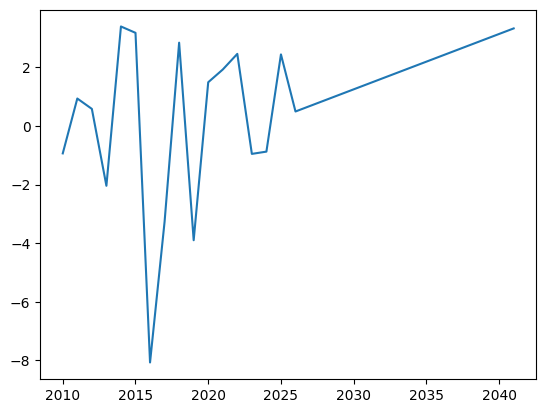

In [262]:



xpoints = np.arange(2010, 2042)
ypoints = inspected_all_arr

plt.plot(xpoints, ypoints)
plt.show()

## Upload predicted weather data to hopsworks

In [558]:
if not fetched_year == -1:
    ski_weather_predicted_fg.insert(psw_df)

2025-12-29 19:27:23,035 INFO: 	3 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/1271967/fs/1258570/fg/1876457


Uploading Dataframe: 100.00% |██| Rows 4392/4392 | Elapsed Time: 00:02 | Remaining Time: 00:00


Launching job: ski_weather_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271967/jobs/named/ski_weather_1_offline_fg_materialization/executions
